In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import torch
import os.path
import pandas as pd
from Bio import Phylo

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


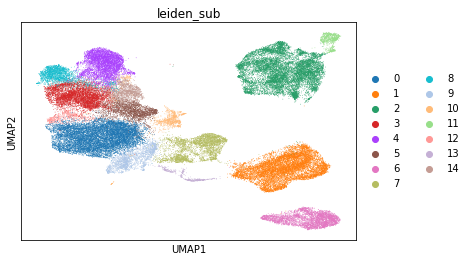

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 25368 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


2022-10-29 15:02:57.081900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 15:02:57.234333: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-29 15:02:57.240422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/torque/lib
2022-10-29 15:02:57.240438: I tensorflow/stream_executor/cuda/cudart_stub.

    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [2]:
adata = scv.read("/data/liangzhen/wangk_DianYang_tumor/RNA_velocity/KPTracer_KP_TRCR_scRNA_6/velocyto/KPTracer_KP_TRCR_scRNA_6.loom",cache=True)
adata.obs_names = ['L6.'+i[25:] for i in adata.obs_names]

wangk_cells_df = pd.read_csv("/data/liangzhen/wangk_DianYang_tumor/data_for_modulescore/cellname_3726.txt",header=None)

adata_paper = scv.read("/data/wangkun/KPTracer-Data/expression/adata_processed.nt.h5ad")
xdr = pd.DataFrame(data=adata_paper.obsm['X_umap'], index=adata_paper.obs.index)
sc.pl.umap(adata_paper, color='leiden_sub')

tree = Phylo.read('/data/wangkun/KPTracer-Data/trees/3726_NT_T1_tree.nwk', format='newick')
sel_cells = np.array([i.name for i in tree.get_terminals()])
sel_cells = sel_cells[np.isin(sel_cells, xdr.index)]
sel_xdr = xdr.loc[sel_cells]

cond = sel_xdr.iloc[:,0]<2
cond = cond & ~((sel_xdr.iloc[:,1]<3)&(sel_xdr.iloc[:,0]<-5.5))
cond = cond & ~((sel_xdr.iloc[:,1]<-5)&(sel_xdr.iloc[:,0]<1)&(sel_xdr.iloc[:,0]>-2))

wangk_cells = cond.index[cond]

adata_paper_select = adata_paper[cond.index[cond],]

wangk_cells = [cell.replace("-1","x") for cell in wangk_cells]
wangk_cells = [cell.replace("L30.","KPTracer_scRNA_L30:") for cell in wangk_cells]

adata_select = adata[wangk_cells,]

adata_select.obsm['X_umap'] = adata_paper_select.obsm['X_umap']
adata_select.obs["leiden_sub"] = adata_paper_select.obs["leiden_sub"].to_list()

scv.pp.filter_and_normalize(adata_select,min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_select,n_pcs=30, n_neighbors=30)


## scVelo - dynamical

recovering dynamics (using 1/64 cores)


  0%|          | 0/1286 [00:00<?, ?gene/s]

    finished (0:02:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/754 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


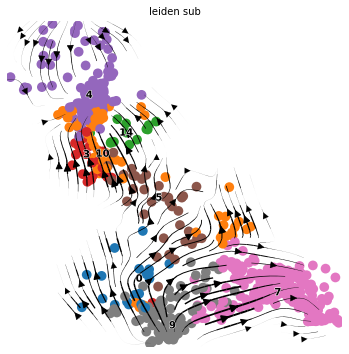

In [3]:
adata_scv = adata_select.copy()

scv.tl.recover_dynamics(adata_scv)
scv.tl.velocity(adata_scv,mode="dynamical")
scv.tl.velocity_graph(adata_scv)
scv.tl.velocity_pseudotime(adata_scv)
scv.pl.velocity_embedding_stream(adata_scv, basis='X_umap',color="leiden_sub",figsize=[6,6],s=380,alpha=1,density=1.5,arrow_size=1.5,smooth=1)

In [4]:
scv.tl.latent_time(adata_scv)

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


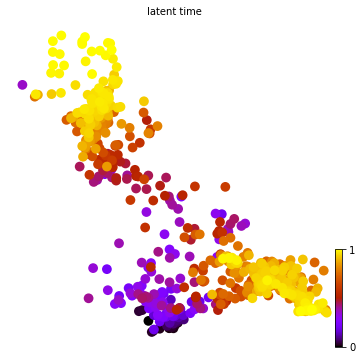

In [5]:
scv.pl.scatter(adata_scv, color='latent_time', color_map='gnuplot',figsize=[6,6],s=380,alpha=1,legend_loc='None')

## deepvelo

In [6]:
from deepvelo.utils import velocity, velocity_confidence, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants
from deepvelo.utils.temporal import latent_time

In [7]:
adata_dv = adata_select.copy()

In [8]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata_dv)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)
configs['n_gpu']=0

The ratio of spliced reads is 76.8% (between 70% and 85%). Suggest using coeff_s 0.75.


In [9]:
velocity(adata_dv, mask_zero=False)
trainer = train(adata_dv, configs)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


INFO:train:Beginning training of DeepVelo ...


building graph
velo data shape: torch.Size([754, 2000])
velo_mat shape: (754, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [10]:
scv.tl.velocity_graph(adata_dv, n_jobs=8)

computing velocity graph (using 8/64 cores)


  0%|          | 0/754 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


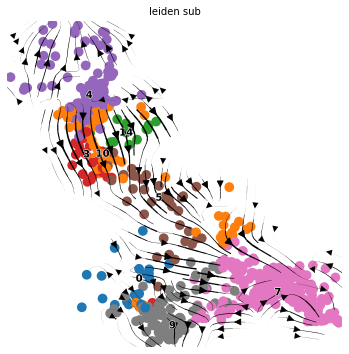

In [11]:
scv.pl.velocity_embedding_stream(adata_dv, basis='X_umap',color="leiden_sub",figsize=[6,6],s=380,alpha=1,density=1.5,arrow_size=1.5,smooth=1)

In [12]:
latent_time(adata_dv)

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


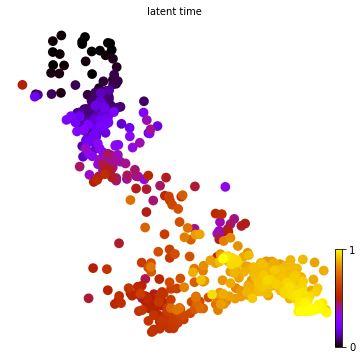

In [13]:
scv.pl.scatter(adata_dv, color='latent_time', color_map='gnuplot',figsize=[6,6],s=380,alpha=1,legend_loc='None')

## UnitVelo

In [14]:
import unitvelo as utv

(Running UniTVelo 0.2.4.3)
2022-10-29 07:05:39


In [15]:
adata_utv = adata_select.copy()

In [16]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = '1'
velo_config.AGENES_R2 = 1

-------> Manully Specified Parameter <-------
None


-------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None


Current working dir is /home/wangkun
Results will be stored in res folder


2022-10-29 15:05:39.678619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/torque/lib
2022-10-29 15:05:39.678677: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-29 15:05:39.678719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (node1): /proc/driver/nvidia/version does not exist
2022-10-29 15:05:39.679393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---> # of velocity genes used 1192
---> # of velocity genes used 1040
---> # of velocity genes used 1037


1,704,411: 100%|█████████████████████████▉| 11998/12000 [07:58<00:00, 23.11it/s]

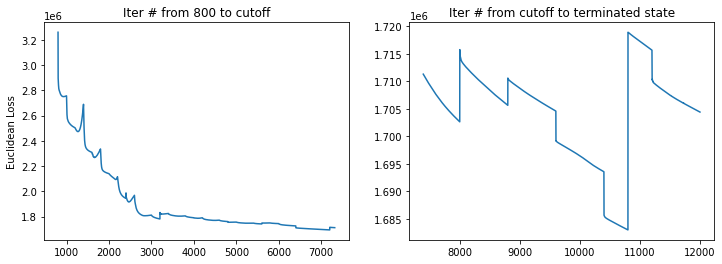

1,704,411: 100%|█████████████████████████▉| 11999/12000 [08:09<00:00, 24.51it/s]

Total loss 1682989, vgene loss 1704411


  0%|          | 0/754 [00:00<?, ?cells/s]

In [17]:
adata = utv.run_model(adata_utv, 'leiden_sub', config_file=velo_config)

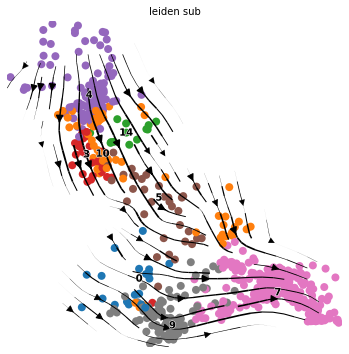

In [18]:
scv.pl.velocity_embedding_stream(adata_utv, color='leiden_sub', basis='X_umap',figsize=[6,6],s=255,alpha=1,density=1,arrow_size=1.5,smooth=1)

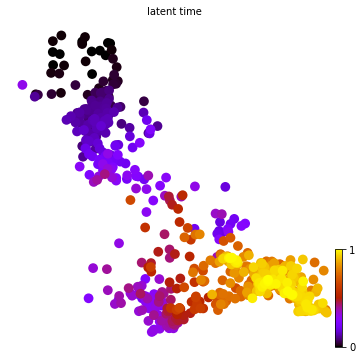

In [19]:
scv.tl.latent_time(adata_utv,min_likelihood=None)
scv.pl.scatter(adata_utv, color='latent_time', color_map='gnuplot',figsize=[6,6],s=380,alpha=1,legend_loc='None')

## VeloVAE

In [20]:
import sys
sys.path.append('/home/wangkun/VeloVAE-master/')
import velovae as vv

In [21]:
adata_vv = adata_select.copy()

In [22]:
torch.manual_seed(2022)
np.random.seed(2022)
full_vb = vv.VAEFullVB(adata_vv, tmax=20, dim_z=5)

Initialization using the steady-state and dynamical models.
Gaussian Prior.


In [23]:
full_vb.train(adata_vv, plot=True, figure_path='/home/wangkun/fullvb/kp3726', embed="umap")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 5, test iteration: 8
Epoch 1: Train ELBO = -102666.477, Test ELBO = -705217.375, 	 Total Time =   0 h :  0 m :  0 s
Epoch 100: Train ELBO = -5215.188, Test ELBO = -5655.866, 	 Total Time =   0 h :  0 m : 20 s
Epoch 200: Train ELBO = -3610.744, Test ELBO = -3941.016, 	 Total Time =   0 h :  0 m : 40 s
Epoch 300: Train ELBO = -2449.842, Test ELBO = -2814.940, 	 Total Time =   0 h :  1 m :  0 s
*********       Stage 1: Early Stop Triggered at epoch 308.    

In [24]:
full_vb.save_anndata(adata_vv, 'fullvb',file_path='/home/wangkun/VeloVAE-master/', file_name="kp3726_out.h5ad")

... storing 'leiden_sub' as categorical


  0%|          | 0/754 [00:00<?, ?cells/s]

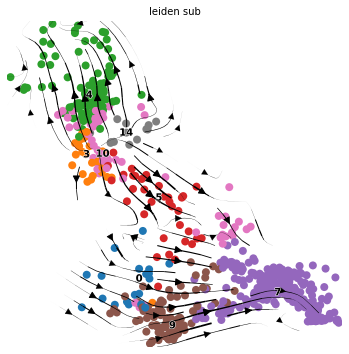

In [25]:
key = 'fullvb'
scv.tl.velocity_graph(adata_vv, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata_vv, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata_vv, vkey=f'{key}_velocity', color='leiden_sub', basis='X_umap',figsize=[6,6],s=255,alpha=1,density=1,arrow_size=1.5,smooth=1)

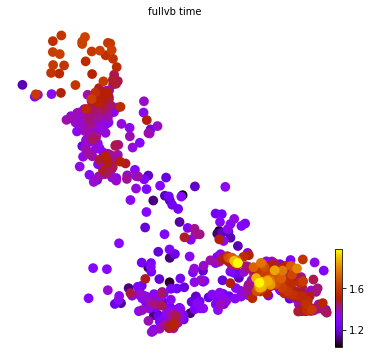

In [26]:
scv.pl.scatter(adata_vv, color='fullvb_time', color_map='gnuplot',figsize=[6,6],s=380,alpha=1,legend_loc='None')

In [27]:
import phylovelo as pv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def norm_time(x):
    x -= min(x)
    return x/max(x)

from matplotlib import font_manager
import matplotlib.patheffects as pe
c = adata_paper.obs['leiden_sub'].astype(int)
c.index = [i.replace('-1', 'x') for i in c.index]

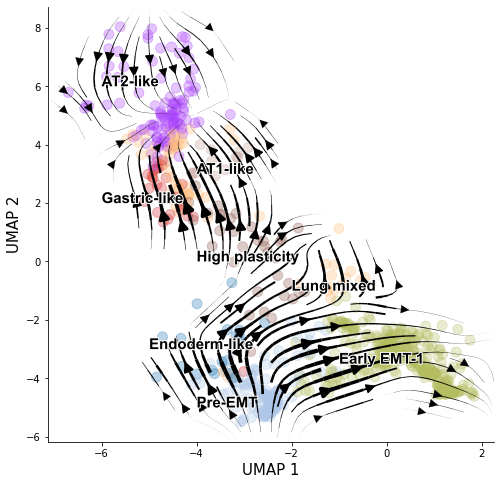

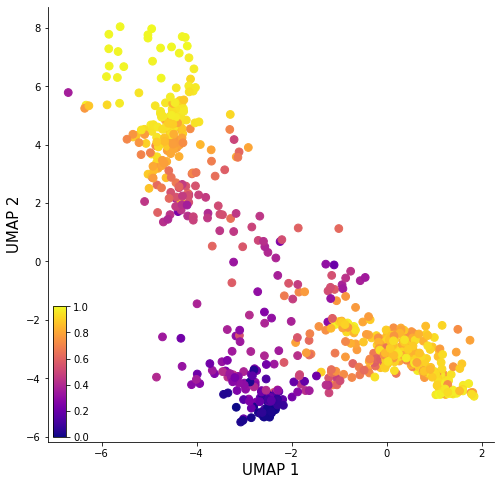

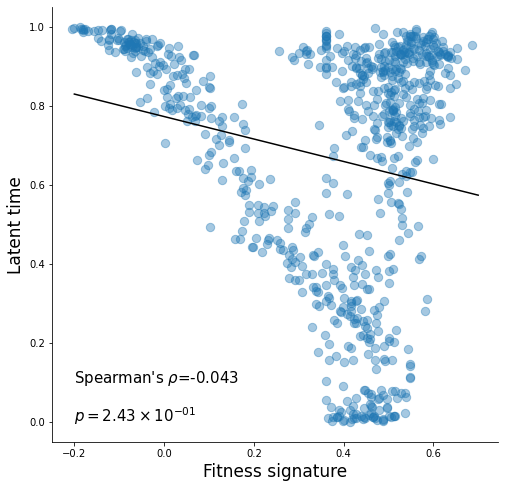

In [35]:
name = 'kp3726_scvelo'
fig, ax = plt.subplots()
ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=c[adata.obs_names].apply(lambda x: adata_paper.uns['leiden_sub_colors'][x]), 
           s=100, alpha=0.3)
ax = pv.ana_utils.velocity_plot(adata.obsm['X_umap'], adata_scv.obsm['velocity_umap'], ax, 'stream', radius=0.8, lw_coef=100, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -5, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-5, -3, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 0, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -1, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 2, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'.png', format='png')


fig, ax = plt.subplots()
scatter=ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=norm_time(adata_scv.obs['latent_time']), cmap='plasma',
           s=60)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower left') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-1.43,9)

plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_lt.png', format='png')


from scipy.stats import spearmanr
sigscores = pd.read_csv("/data/liangzhen/wangk_DianYang_tumor/data_for_modulescore/fitness_signature_scores.tsv", sep='\t', index_col = 0)
kii = np.intersect1d(sigscores.index, adata_paper.obs_names)
adata_paper.obs['FitnessSignature'] = np.nan
adata_paper.obs.loc[kii, 'FitnessSignature'] = sigscores.loc[kii, 'FitnessSignature_NT']


x =adata_paper.obs['FitnessSignature'][[i.replace('x', '-1') for i in adata.obs_names]]
y = norm_time(np.array(adata_scv.obs['latent_time']))
x[np.isnan(x)] = np.mean(x[~np.isnan(x)])

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(-0.2,0.7,60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(-0.2,0.7,60), y_est, '-', c='k')
ax.set_xlabel('Fitness signature', fontsize=17)
ax.set_ylabel('Latent time', fontsize=17)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(-0.2, 0.1, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(-0.2, 0.0, r'$p={}\times 10^{}$'.format(*r'{:.2e}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_cmp.png', format='png')

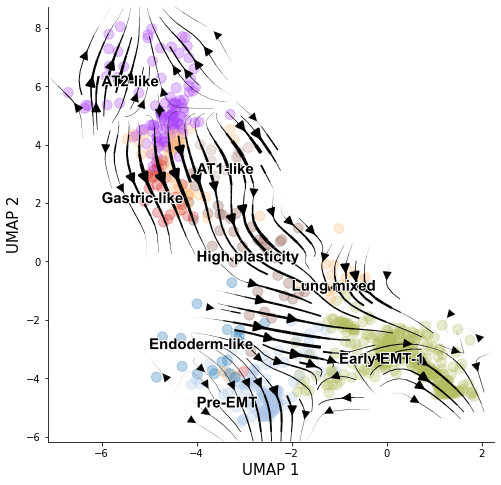

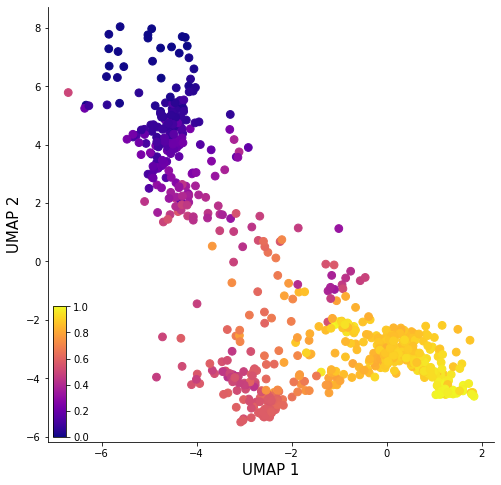

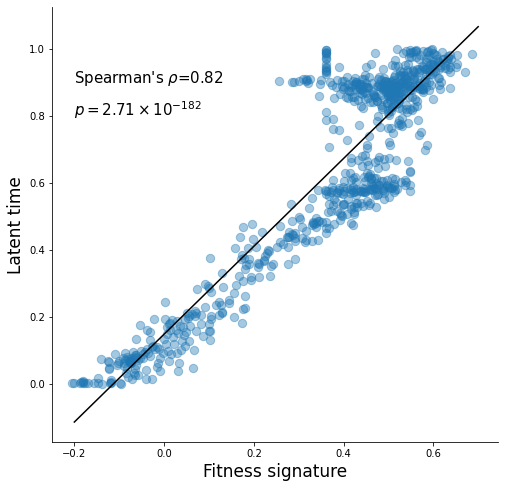

In [37]:
name = 'kp3726_deepvelo'
fig, ax = plt.subplots()
ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=c[adata.obs_names].apply(lambda x: adata_paper.uns['leiden_sub_colors'][x]), 
           s=100, alpha=0.3)
ax = pv.ana_utils.velocity_plot(adata.obsm['X_umap'], adata_dv.obsm['velocity_umap'], ax, 'stream', radius=0.8, lw_coef=100, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -5, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-5, -3, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 0, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -1, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 2, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'.png', format='png')


fig, ax = plt.subplots()
scatter=ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=norm_time(adata_dv.obs['latent_time']), cmap='plasma',
           s=60)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower left') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-1.43,9)

plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_lt.png', format='png')


from scipy.stats import spearmanr
sigscores = pd.read_csv("/data/liangzhen/wangk_DianYang_tumor/data_for_modulescore/fitness_signature_scores.tsv", sep='\t', index_col = 0)
kii = np.intersect1d(sigscores.index, adata_paper.obs_names)
adata_paper.obs['FitnessSignature'] = np.nan
adata_paper.obs.loc[kii, 'FitnessSignature'] = sigscores.loc[kii, 'FitnessSignature_NT']


x =adata_paper.obs['FitnessSignature'][[i.replace('x', '-1') for i in adata.obs_names]]
y = norm_time(np.array(adata_dv.obs['latent_time']))
x[np.isnan(x)] = np.mean(x[~np.isnan(x)])

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(-0.2,0.7,60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(-0.2,0.7,60), y_est, '-', c='k')
ax.set_xlabel('Fitness signature', fontsize=17)
ax.set_ylabel('Latent time', fontsize=17)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(-0.2, 0.9, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(-0.2, 0.8, r'$p={}\times 10^{}$'.format(*r'{:.2e}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_cmp.png', format='png')

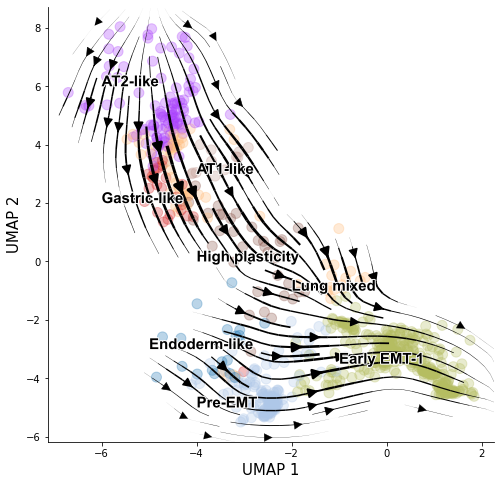

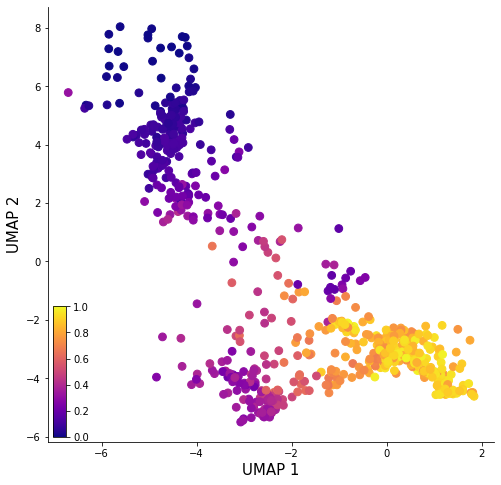

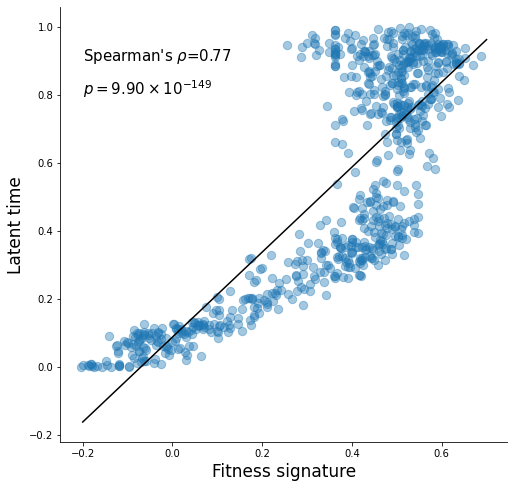

In [38]:
name = 'kp3726_unitvelo'
fig, ax = plt.subplots()
ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=c[adata.obs_names].apply(lambda x: adata_paper.uns['leiden_sub_colors'][x]), 
           s=100, alpha=0.3)
ax = pv.ana_utils.velocity_plot(adata.obsm['X_umap'], adata_utv.obsm['velocity_umap'], ax, 'stream', radius=0.8, lw_coef=100, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -5, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-5, -3, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 0, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -1, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 2, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'.png', format='png')


fig, ax = plt.subplots()
scatter=ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=norm_time(adata_utv.obs['latent_time']), cmap='plasma',
           s=60)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower left') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-1.43,9)

plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_lt.png', format='png')


from scipy.stats import spearmanr
sigscores = pd.read_csv("/data/liangzhen/wangk_DianYang_tumor/data_for_modulescore/fitness_signature_scores.tsv", sep='\t', index_col = 0)
kii = np.intersect1d(sigscores.index, adata_paper.obs_names)
adata_paper.obs['FitnessSignature'] = np.nan
adata_paper.obs.loc[kii, 'FitnessSignature'] = sigscores.loc[kii, 'FitnessSignature_NT']


x =adata_paper.obs['FitnessSignature'][[i.replace('x', '-1') for i in adata.obs_names]]
y = norm_time(np.array(adata_utv.obs['latent_time']))
x[np.isnan(x)] = np.mean(x[~np.isnan(x)])

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(-0.2,0.7,60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(-0.2,0.7,60), y_est, '-', c='k')
ax.set_xlabel('Fitness signature', fontsize=17)
ax.set_ylabel('Latent time', fontsize=17)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(-0.2, 0.9, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(-0.2, 0.8, r'$p={}\times 10^{}$'.format(*r'{:.2e}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_cmp.png', format='png')

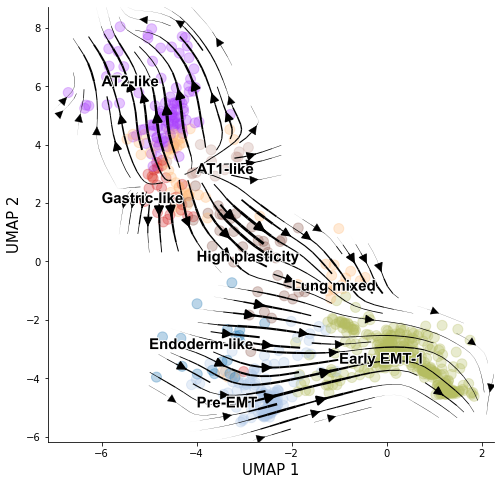

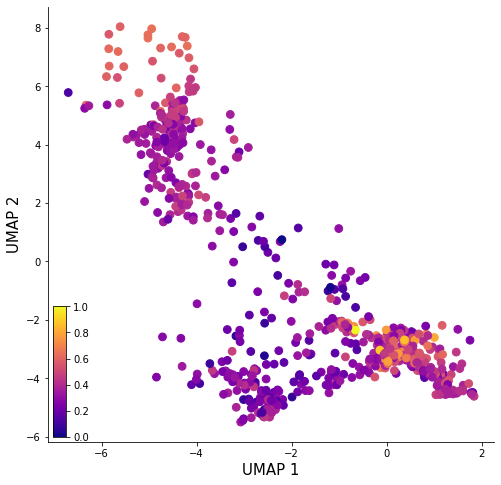

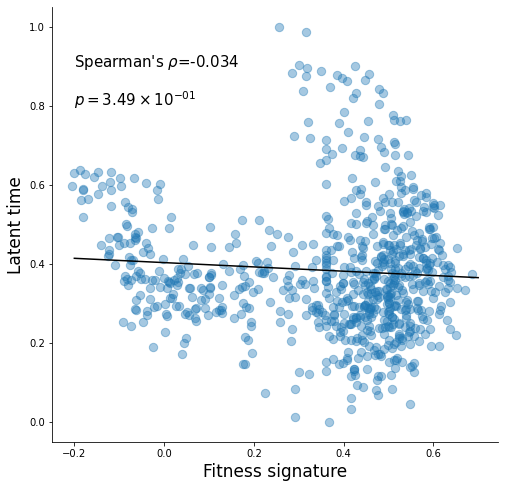

In [40]:
name = 'kp3726_velovae'
fig, ax = plt.subplots()
ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=c[adata.obs_names].apply(lambda x: adata_paper.uns['leiden_sub_colors'][x]), 
           s=100, alpha=0.3)
ax = pv.ana_utils.velocity_plot(adata.obsm['X_umap'], adata_vv.obsm['fullvb_velocity_umap'], ax, 'stream', radius=0.8, lw_coef=100, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -5, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-5, -3, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 0, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -1, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 2, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'.png', format='png')


fig, ax = plt.subplots()
scatter=ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=norm_time(adata_vv.obs['fullvb_time']), cmap='plasma',
           s=60)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower left') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-1.43,9)

plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_lt.png', format='png')


from scipy.stats import spearmanr
sigscores = pd.read_csv("/data/liangzhen/wangk_DianYang_tumor/data_for_modulescore/fitness_signature_scores.tsv", sep='\t', index_col = 0)
kii = np.intersect1d(sigscores.index, adata_paper.obs_names)
adata_paper.obs['FitnessSignature'] = np.nan
adata_paper.obs.loc[kii, 'FitnessSignature'] = sigscores.loc[kii, 'FitnessSignature_NT']


x =adata_paper.obs['FitnessSignature'][[i.replace('x', '-1') for i in adata.obs_names]]
y = norm_time(np.array(adata_vv.obs['fullvb_time']))
x[np.isnan(x)] = np.mean(x[~np.isnan(x)])

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(-0.2,0.7,60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(-0.2,0.7,60), y_est, '-', c='k')
ax.set_xlabel('Fitness signature', fontsize=17)
ax.set_ylabel('Latent time', fontsize=17)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(-0.2, 0.9, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(-0.2, 0.8, r'$p={}\times 10^{}$'.format(*r'{:.2e}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_cmp.png', format='png')